# Traffic Forecasting with Pytorch Geometric Temporal


## Installation

In [1]:
import torch
from IPython.display import clear_output
pt_version = torch.__version__
print(pt_version)

1.11.0


In [2]:
import numpy as np

This took some time for me, so be patient :)

## Dataset
- Traffic forecasting dataset based on Los Angeles Metropolitan traffic 
- 207 loop detectors on highways
- March 2012 - June 2012
- From the paper: Diffusion Convolutional Recurrent Neural Network


In [3]:
from torch_geometric_temporal.dataset import METRLADatasetLoader
loader = METRLADatasetLoader()
dataset = loader.get_dataset(num_timesteps_in=12, num_timesteps_out=12)
print("Dataset type:  ", dataset)
print("Number of samples / sequences: ",  len(set(dataset)))

Dataset type:   <torch_geometric_temporal.signal.static_graph_temporal_signal.StaticGraphTemporalSignal object at 0x00000239839697C0>
Number of samples / sequences:  34249


#### Data Sample
- 207 nodes
- 2 features per node (speed, time)
- 12 timesteps per bucket (12 x 5 min = 60 min) 
- Labels for 12 future timesteps (normalized speed) --> node regression
- Edge_attr is build based on the distances between sensors + threshold
- Further details: https://pytorch-geometric-temporal.readthedocs.io/en/latest/_modules/torch_geometric_temporal/dataset/metr_la.html#METRLADatasetLoader
- Raw data: https://graphmining.ai/temporal_datasets/METR-LA.zip

In [4]:
# Show first sample
next(iter(dataset))

Data(x=[207, 2, 12], edge_index=[2, 1722], edge_attr=[1722], y=[207, 12])

In [ ]:
import seaborn as sns
# Visualize traffic over time
sensor_number = 1
hours = 24
sensor_labels = [bucket.y[sensor_number][0].item() for bucket in list(dataset)[:hours]]
sns.lineplot(data=sensor_labels)

#### Test Train Split

In [5]:
from torch_geometric_temporal.signal import temporal_signal_split
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

print("Number of train buckets: ", len(set(train_dataset)))
print("Number of test buckets: ", len(set(test_dataset)))

Number of train buckets:  27399
Number of test buckets:  6850


## Model

Which model to choose depends on which time-series task you work on. 

- A3TGCN is an extension of TGCN that uses attention 
- The spatial aggregation uses GCN, the temporal aggregation a GRU
- We can pass in periods to get an embedding for several timesteps
- This embedding can be used to predict several steps into the future = output dimension
- We could also do this in a loop and feed it again into the model (would be autoregressive)
- There is only one block here. Other layers also allow stacking???

In [6]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import A3TGCN

class TemporalGNN(torch.nn.Module):
    def __init__(self, node_features, periods):
        super(TemporalGNN, self).__init__()
        # Attention Temporal Graph Convolutional Cell
        self.tgnn = A3TGCN(in_channels=node_features, 
                           out_channels=32, 
                           periods=periods)
        # Equals single-shot prediction
        self.linear = torch.nn.Linear(32, periods)

    def forward(self, x, edge_index):
        """
        x = Node features for T time steps
        edge_index = Graph edge indices
        """
        h = self.tgnn(x, edge_index)
        h = F.relu(h)
        h = self.linear(h)
        return h

TemporalGNN(node_features=2, periods=12)

TemporalGNN(
  (tgnn): A3TGCN(
    (_base_tgcn): TGCN(
      (conv_z): GCNConv(2, 32)
      (linear_z): Linear(in_features=64, out_features=32, bias=True)
      (conv_r): GCNConv(2, 32)
      (linear_r): Linear(in_features=64, out_features=32, bias=True)
      (conv_h): GCNConv(2, 32)
      (linear_h): Linear(in_features=64, out_features=32, bias=True)
    )
  )
  (linear): Linear(in_features=32, out_features=12, bias=True)
)

In [11]:
!pip install torchsummary

In [18]:
from torchvision import models
device = torch.device('cpu') # cuda
model = models.TemporalGNN(node_features=2, periods=12).to(device)

model

AttributeError: module 'torchvision.models' has no attribute 'TemporalGNN'

## Training

- Training on GPU didn't bring much speed-up
- I ran into RAM issues, why I only train on a smaller subset of the data

In [7]:
torch.cuda.empty_cache()

In [18]:
import math

In [27]:
# GPU support

device = torch.device('cpu') # cuda
subset = 2000
running_mae = 0
running_mse = 0

# Create model and optimizers
model = TemporalGNN(node_features=2, periods=12).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model.train()
rmse =[]
mae = []

print("Running training...")
for epoch in range(10): 
    loss = 0
    step = 0
    for snapshot in train_dataset:
        snapshot = snapshot.to(device)
        # Get model predictions
        y_hat = model(snapshot.x, snapshot.edge_index)
        # Mean squared error
        loss = loss + torch.mean(abs(y_hat-snapshot.y)) 
        
        error = torch.abs(y_hat-snapshot.y).sum().data
        squared_error = ((y_hat-snapshot.y)*(y_hat-snapshot.y)).sum().data
        running_mae += error
        running_mse += squared_error
        
        
        step += 1
        if step > subset:
          break
        
    
    rmse.append(math.sqrt(running_mse/10))
    mae.append(running_mae/10)
    
    loss = loss / (step + 1)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
        
    print("Epoch {} train MAE: {:.4f}".format(epoch, loss.item()))
    
    print(sum(rmse))
    print(sum(mae))
    print(sum(rmse)/len(rmse))
    print(sum(mae)/len(mae))



Running training...
Epoch 0 train MAE: 0.6670
611.6582225802249
tensor(331710.)
611.6582225802249
tensor(331710.)
Epoch 1 train MAE: 0.6479
1472.9140643601227
tensor(985629.5625)
736.4570321800613
tensor(492814.7812)
Epoch 2 train MAE: 0.6304
2523.858282670495
tensor(1953042.7500)
841.2860942234984
tensor(651014.2500)
Epoch 3 train MAE: 0.6112
3733.2032499978495
tensor(3224423.)
933.3008124994624
tensor(806105.7500)
Epoch 4 train MAE: 0.5894
5080.763870155622
tensor(4788911.)
1016.1527740311243
tensor(957782.1875)
Epoch 5 train MAE: 0.5655
6552.288759513596
tensor(6634608.)
1092.0481265855994
tensor(1105768.)
Epoch 6 train MAE: 0.5415
8137.411625413903
tensor(8749589.)
1162.487375059129
tensor(1249941.2500)
Epoch 7 train MAE: 0.5198
9828.616964809447
tensor(11123088.)
1228.577120601181
tensor(1390386.)
Epoch 8 train MAE: 0.5032
11620.565694544759
tensor(13746839.)
1291.1739660605288
tensor(1527426.5000)
Epoch 9 train MAE: 0.4933
13509.36518099111
tensor(16615910.)
1350.936518099111
ten

In [26]:
print(sum(rmse))
print(sum(mae))
print(sum(rmse)/len(rmse))
print(sum(mae)/len(mae))

612.7315123689983
tensor(332989.5312)
612.7315123689983
tensor(332989.5312)


In [30]:
# GPU support

device = torch.device('cpu') # cuda
subset = 2000

# Create model and optimizers
model = TemporalGNN(node_features=2, periods=12).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model.train()

print("Running training...")
for epoch in range(10): 
    loss = 0
    step = 0
    for snapshot in train_dataset:
        snapshot = snapshot.to(device)
        # Get model predictions
        y_hat = model(snapshot.x, snapshot.edge_index)
        # Mean squared error
        loss = loss + torch.mean((y_hat-snapshot.y)**2) 
        step += 1
        if step > subset:
          break

    loss = loss / (step + 1)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    print("Epoch {} train MSE: {:.4f}".format(epoch, loss.item()))

Running training...
Epoch 0 train MSE: 0.7485
Epoch 1 train MSE: 0.7286
Epoch 2 train MSE: 0.7085
Epoch 3 train MSE: 0.6871
Epoch 4 train MSE: 0.6652
Epoch 5 train MSE: 0.6448
Epoch 6 train MSE: 0.6280
Epoch 7 train MSE: 0.6148
Epoch 8 train MSE: 0.6026
Epoch 9 train MSE: 0.5890


## Evaluation

- Lets get some sample predictions for a specific horizon (e.g. 288/12 = 24 hours)
- The model always gets one hour and needs to predict the next hour

In [8]:
model.eval()
loss = 0
step = 0
horizon = 288

# Store for analysis
predictions = []
labels = []

for snapshot in test_dataset:
    snapshot = snapshot.to(device)
    # Get predictions
    y_hat = model(snapshot.x, snapshot.edge_index)
    # Mean squared error
    loss = loss + torch.mean(abs(y_hat-snapshot.y))
    # Store for analysis below
    labels.append(snapshot.y)
    predictions.append(y_hat)
    step += 1
    if step > horizon:
          break

loss = loss / (step+1)
loss = loss.item()
print("Test MAE: {:.4f}".format(loss))

Test MAE: 0.5451


In [31]:
model.eval()
loss = 0
step = 0
horizon = 288

# Store for analysis
predictions = []
labels = []

for snapshot in test_dataset:
    snapshot = snapshot.to(device)
    # Get predictions
    y_hat = model(snapshot.x, snapshot.edge_index)
    # Mean squared error
    loss = loss + torch.mean((y_hat-snapshot.y)**2)
    # Store for analysis below
    labels.append(snapshot.y)
    predictions.append(y_hat)
    step += 1
    if step > horizon:
          break

loss = loss / (step+1)
loss = loss.item()
print("Test MSE: {:.4f}".format(loss))

Test MSE: 0.6930


### Visualization

- The further away the point in time is, the worse the predictions get
- Predictions shape: [num_data_points, num_sensors, num_timesteps]

In [32]:
import numpy as np

sensor = 123
timestep = 11 
preds = np.asarray([pred[sensor][timestep].detach().cpu().numpy() for pred in predictions])
labs  = np.asarray([label[sensor][timestep].cpu().numpy() for label in labels])
print("Data points:,", preds.shape)

Data points:, (289,)


In [ ]:
import matplotlib.pyplot as plt 
import seaborn as sns

plt.figure(figsize=(20,5))
sns.lineplot(data=preds, label="pred")
sns.lineplot(data=labs, label="true")

# Spatial features only

In [21]:
from torch_geometric_temporal.dataset import METRLADatasetLoader
loader = METRLADatasetLoader()
dataset = loader.get_dataset(num_timesteps_in=1, num_timesteps_out=1)
print("Dataset type:  ", dataset)
print("Number of samples / sequences: ",  len(set(dataset)))

Dataset type:   <torch_geometric_temporal.signal.static_graph_temporal_signal.StaticGraphTemporalSignal object at 0x000001869E17D430>
Number of samples / sequences:  34271


In [22]:
next(iter(dataset))

Data(x=[207, 2, 1], edge_index=[2, 1722], edge_attr=[1722], y=[207, 1])

In [32]:
from torch.nn import Linear, ReLU
from torch_geometric.nn import Sequential, GCNConv

model = Sequential('x, edge_index', [
    (GCNConv(1, 64), 'x, edge_index -> x'),
    ReLU(inplace=True),
    (GCNConv(64, 64), 'x, edge_index -> x'),
    ReLU(inplace=True),
    Linear(64, 1),
])

In [33]:
import torch

In [34]:
torch.cuda.empty_cache()

In [15]:
loss_values = [6.25,3.927,3.926,3.925,3.924,3.923,3.922,3.922,3.921,3.921]
val_values = [3.93,3.94,3.93,3.96,3.95,3.93,3.91,3.92,3.909,3.90]

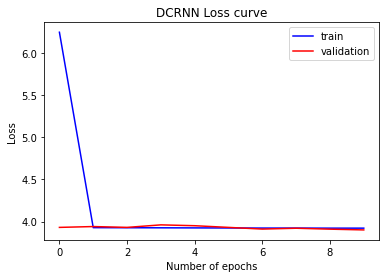

In [17]:
import matplotlib.pyplot as plt

plt.plot(loss_values,'b-',label = 'train')
plt.plot(val_values,'r-', label = 'validation')
plt.legend(loc="upper right")
plt.title("DCRNN Loss curve")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.savefig('foo.png')
plt.show()


loss_values = [0.66,0.64,0.63,0.61,0.58,0.56,0.53,0.50,0.48,0.487]

import matplotlib.pyplot as plt

plt.plot(loss_values,'b-',label = 'train')
plt.legend(loc="upper right")
plt.title("A3TGCN Loss curve")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.savefig('foo.png')
plt.show()

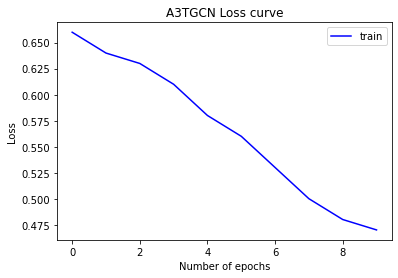

In [14]:
loss_values = [0.66,0.64,0.63,0.61,0.58,0.56,0.53,0.50,0.48,0.47]

import matplotlib.pyplot as plt

plt.plot(loss_values,'b-',label = 'train')
plt.legend(loc="upper right")
plt.title("A3TGCN Loss curve")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.savefig('foo.png')
plt.show()
